In [44]:
import sys
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from argparse import ArgumentParser
import holidays
import optuna
from models.D_PAD_adpGCN import DPAD_GCN
from models.LSTM import LSTM
from models.GRU import GRU
from models.MLP import MLP
from models.xPatch import xPatch
from models.PatchMixer import PatchMixer
from models.Fredformer import Fredformer
import argparse
from itertools import combinations

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.utils import resample
from sklearn.multioutput import MultiOutputRegressor
import ast

from joblib import Parallel, delayed


import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, Sampler

import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import BasePredictionWriter
from lightning.pytorch import seed_everything

# Seed 
SEED = 42
seed_everything(SEED, workers=True)

def convert_Colorado_to_hourly(data):

    # Remove unnecessary columns
    data = data.drop(columns=['Zip_Postal_Code'])

    # Convert date/time columns to datetime
    data['Start_DateTime'] = pd.to_datetime(data['Start_DateTime'])
    data['Charging_EndTime'] = pd.to_datetime(data['End_DateTime'])
    data['Charging_Time'] = pd.to_timedelta(data['Charging_Time'])

    ####################### CONVERT DATASET TO HOURLY  #######################

    # Split the session into hourly intervals
    hourly_rows = []

    # Iterate over each row in the dataframe to break charging sessions into hourly intervals
    for _, row in data.iterrows():
        start, end = row['Start_DateTime'], row['Charging_EndTime']
        energy = row['Energy_Consumption']

        # Generate hourly intervals
        hourly_intervals = pd.date_range(
            start=start.floor('h'), end=end.ceil('h'), freq='h')
        total_duration = (end - start).total_seconds()

        for i in range(len(hourly_intervals) - 1):
            interval_start = max(start, hourly_intervals[i])
            interval_end = min(end, hourly_intervals[i+1])
            interval_duration = (interval_end - interval_start).total_seconds()

            # Calculate the energy consumption for the interval if interval is greater than 0 (Start and end time are different)
            if interval_duration > 0:
                energy_fraction = (interval_duration / total_duration) * energy

            hourly_rows.append({
                'Time': hourly_intervals[i],
                'Energy_Consumption': energy_fraction,
                "Session_Count": 1  # Count of sessions in the interval
            })

    # Create a new dataframe from the hourly intervals
    hourly_df = pd.DataFrame(hourly_rows)

    # Aggregate the hourly intervals
    hourly_df = hourly_df.groupby('Time').agg({
        'Energy_Consumption': 'sum',
        'Session_Count': 'sum'
    }).reset_index()

    # Convert the Time column to datetime
    hourly_df['Time'] = pd.to_datetime(
        hourly_df['Time'], format="%d-%m-%Y %H:%M:%S")
    hourly_df = hourly_df.set_index('Time')

    # Define time range for all 24 hours
    start_time = hourly_df.index.min().normalize()  # 00:00:00
    end_time = hourly_df.index.max().normalize() + pd.Timedelta(days=1) - \
        pd.Timedelta(hours=1)  # 23:00:00

    # Change range to time_range_full, so from 00:00:00 to 23:00:00
    time_range_full = pd.date_range(start=start_time, end=end_time, freq='h')

    # Reindex the hourly data to include all hours in the range
    hourly_df = hourly_df.reindex(time_range_full, fill_value=0)

    # Return the hourly data
    return hourly_df

def convert_SDU_to_hourly(df):
  df = df.set_index('Timestamp')

  hourly = df.resample('h').agg({
      'Total number of EVs':      'sum',
      'Number of charging EVs':   'sum',
      'Number of driving EVs':    'sum',
      'Total grid load':          'sum',
      'Aggregated base load':     'sum',
      'Aggregated charging load': 'sum',
      'Overload duration [min]':  'sum',
  })

  return hourly

def add_features(hourly_df, dataset_name, historical_feature, weather_df=None):
  ####################### TIMED BASED FEATURES  #######################
  hourly_df['Day_of_Week'] = hourly_df.index.dayofweek

  # Add hour of the day
  hourly_df['Hour_of_Day'] = hourly_df.index.hour

  # Add month of the year
  hourly_df['Month_of_Year'] = hourly_df.index.month

  # Add year
  hourly_df['Year'] = hourly_df.index.year

  # Add day/night
  hourly_df['Day/Night'] = (hourly_df['Hour_of_Day'] >= 6) & (hourly_df['Hour_of_Day'] <= 18)

  # Add holiday
  if dataset_name == 'Colorado':
    us_holidays = holidays.US(years=range(hourly_df.index.year.min(), hourly_df.index.year.max() + 1))
    hourly_df['IsHoliday'] = hourly_df.index.to_series().dt.date.isin(us_holidays).astype(int)
  elif dataset_name == 'SDU':
    dk_holidays = holidays.DK(years=range(
        hourly_df.index.year.min(), hourly_df.index.year.max() + 1))
    hourly_df['IsHoliday'] = hourly_df.index.to_series().dt.date.isin(dk_holidays).astype(int)

  # Add weekend
  hourly_df['Weekend'] = (hourly_df['Day_of_Week'] >= 5).astype(int)

  ####################### CYCLIC FEATURES  #######################
  # Cos and sin transformations for cyclic features (hour of the day, day of the week, month of the year)

  hourly_df['HourSin'] = np.sin(2 * np.pi * hourly_df['Hour_of_Day'] / 24)
  hourly_df['HourCos'] = np.cos(2 * np.pi * hourly_df['Hour_of_Day'] / 24)
  hourly_df['DayOfWeekSin'] = np.sin(2 * np.pi * hourly_df['Day_of_Week'] / 7)
  hourly_df['DayOfWeekCos'] = np.cos(2 * np.pi * hourly_df['Day_of_Week'] / 7)
  hourly_df['MonthOfYearSin'] = np.sin(2 * np.pi * hourly_df['Month_of_Year'] / 12)
  hourly_df['MonthOfYearCos'] = np.cos(2 * np.pi * hourly_df['Month_of_Year'] / 12)

  ####################### SEASONAL FEATURES  #######################
  # 0 = Spring, 1 = Summer, 2 = Autumn, 3 = Winter
  month_to_season = {1: 4, 2: 4, 3: 0, 4: 0, 5: 0, 6: 1,
                     7: 1, 8: 1, 9: 2, 10: 2, 11: 2, 12: 3}
  hourly_df['Season'] = hourly_df['Month_of_Year'].map(month_to_season)

  ####################### WEATHER FEATURES  #######################
  if weather_df is not None:
    weather_df = pd.read_csv(weather_df, parse_dates=['time']).set_index(
        'time').rename(columns={'temperature': 'Temperature'})

    # make sure tempture is a number
    weather_df['Temperature'] = pd.to_numeric(
        weather_df['Temperature'], errors='coerce')

    hourly_df = hourly_df.join(weather_df, how='left')

  ####################### HISTORICAL CONSUMPTION FEATURES  #######################
  # Lag features
  # 1h
  hourly_df['Energy_Consumption_1h'] = hourly_df[historical_feature].shift(1)

  # 6h
  hourly_df['Energy_Consumption_6h'] = hourly_df[historical_feature].shift(6)

  # 12h
  hourly_df['Energy_Consumption_12h'] = hourly_df[historical_feature].shift(
      12)

  # 24h
  hourly_df['Energy_Consumption_24h'] = hourly_df[historical_feature].shift(
      24)

  # 1 week
  hourly_df['Energy_Consumption_1w'] = hourly_df[historical_feature].shift(
      24*7)

  # Rolling average
  # 24h
  hourly_df['Energy_Consumption_rolling'] = hourly_df[historical_feature].rolling(window=24).mean()

  return hourly_df

def filter_data(start_date, end_date, data):
    ####################### FILTER DATASET  #######################
    data = data[(data.index >= start_date) & (data.index <= end_date)].copy()
    # print(data.head())

    return data


class TimeSeriesDataset(Dataset):
  def __init__(self, X: np.ndarray, y: np.ndarray, seq_len: int = 1, pred_len: int = 24, stride: int = 24):
    self.seq_len = seq_len
    self.pred_len = pred_len
    self.stride = stride

    if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
    if isinstance(y, pd.Series):
        y = y.to_numpy()

    # Ensure data is numeric and handle non-numeric values
    X = np.asarray(X, dtype=np.float32)
    y = np.asarray(y, dtype=np.float32)

    self.X = torch.tensor(X).float()
    self.y = torch.tensor(y).float()

  def __len__(self):
    return (len(self.X) - (self.seq_len + self.pred_len - 1)) // self.stride + 1

  def __getitem__(self, index):
    start_idx = index * self.stride
    x_window = self.X[start_idx: start_idx + self.seq_len]
    y_target = self.y[start_idx + self.seq_len: start_idx + self.seq_len + self.pred_len]
    return x_window, y_target

class BootstrapSampler:
    def __init__(self, dataset_size, random_state=None):
        self.dataset_size = dataset_size
        self.random_state = random_state

    def __iter__(self):
        indices = resample(range(self.dataset_size), replace=True,
                           n_samples=self.dataset_size, random_state=self.random_state)
        return iter(indices)

    def __len__(self):
        return self.dataset_size

def process_window(i, X, y, seq_len, pred_len):
  X_win = X[i:i + seq_len]
  y_tar = y[i + seq_len:i + seq_len + pred_len]
  arr_x = np.asanyarray(X_win).reshape(-1)
  arr_y = np.asanyarray(y_tar).reshape(-1)
  return arr_x, arr_y

class ColoradoDataModule(L.LightningDataModule):
  def __init__(self, data_dir: str, scaler: int, seq_len: int, pred_len: int, stride: int, batch_size: int, num_workers: int, is_persistent: bool):
    super().__init__()
    self.data_dir = data_dir
    self.scaler = scaler
    self.seq_len = seq_len
    self.pred_len = pred_len
    self.stride = stride
    self.batch_size = batch_size
    self.num_workers = num_workers
    self.is_persistent = is_persistent
    self.X_train = None
    self.y_train = None
    self.X_val = None
    self.y_val = None
    self.X_test = None
    self.y_test = None

  def setup(self, stage: str):
    start_date = pd.to_datetime('2021-05-30')
    end_date = pd.to_datetime('2023-05-30')

    # Load and preprocess the data
    data = pd.read_csv(self.data_dir)
    data = convert_Colorado_to_hourly(data)
    data = add_features(data, dataset_name='Colorado', historical_feature='Energy_Consumption', weather_df='Colorado/denver_weather.csv')
    df = filter_data(start_date, end_date, data)

    df = df.dropna()

    X = df.copy()

    y = X.pop('Energy_Consumption')

    # 60/20/20 split
    X_tv, self.X_test, y_tv, self.y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X_tv, y_tv, test_size=0.25, shuffle=False)

    preprocessing = self.scaler
    preprocessing.fit(self.X_train)  # should only fit to training data
    
    if stage == "fit" or stage is None:
      self.X_train = preprocessing.transform(self.X_train)
      self.y_train = np.array(self.y_train)

    if stage == "test" or "predict" or stage is None:
      self.X_test = preprocessing.transform(self.X_test)
      self.y_test = np.array(self.y_test)

  def train_dataloader(self):
    train_dataset = TimeSeriesDataset(self.X_train, self.y_train, seq_len=self.seq_len, pred_len=self.pred_len, stride=self.stride)
    if args.individual == "True":
      train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent, drop_last=False)
    else:
      sampler = BootstrapSampler(len(train_dataset), random_state=SEED)
      train_loader = DataLoader(train_dataset, batch_size=self.batch_size, sampler=sampler, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent)
    return train_loader
  
  def predict_dataloader(self):
    test_dataset = TimeSeriesDataset(self.X_test, self.y_test, seq_len=self.seq_len, pred_len=self.pred_len, stride=self.stride)
    test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent, drop_last=False)
    return test_loader
  
  def sklearn_setup(self, set_name: str = "train"):
    if set_name == "train":
        if args.individual == "True":
          X, y = self.X_train, self.y_train
        else:
          X, y = resample(self.X_train, self.y_train, replace=True, n_samples=len(self.X_train), random_state=SEED)
    elif set_name == "val":
        X, y = self.X_val, self.y_val
    elif set_name == "test":
        X, y = self.X_test, self.y_test
    else:
        raise ValueError("Invalid set name. Choose from 'train', 'val', or 'test'.")

    seq_len, pred_len, stride = self.seq_len, self.pred_len, self.stride
    max_start = len(X) - (seq_len + pred_len) + 1

    # Parallelize the loop
    results = Parallel(n_jobs=-1)(
        delayed(process_window)(i, X, y, seq_len, pred_len) for i in range(0, max_start, stride)
    )

    # Unpack results
    X_window, y_target = zip(*results)
    return np.array(X_window), np.array(y_target)
    
class SDUDataModule(L.LightningDataModule):
  def __init__(self, data_dir: str, scaler: int, seq_len: int, pred_len: int, stride: int, batch_size: int, num_workers: int, is_persistent: bool):
    super().__init__()
    self.data_dir = data_dir
    self.scaler = scaler
    self.seq_len = seq_len
    self.pred_len = pred_len
    self.stride = stride
    self.batch_size = batch_size
    self.num_workers = num_workers
    self.is_persistent = is_persistent
    self.X_train = None
    self.y_train = None
    self.X_val = None
    self.y_val = None
    self.X_test = None
    self.y_test = None

  def setup(self, stage: str):
    start_date = pd.to_datetime('2024-12-31')
    end_date = pd.to_datetime('2032-12-31')

    # Load the data
    # df = pd.read_csv(self.data_dir, parse_dates=['Timestamp'])
    df = pd.read_csv(self.data_dir, skipinitialspace=True)
    df.columns = df.columns.str.strip()
    df['Timestamp'] = df['Timestamp'].str.strip()  # <-- Add this line
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%b %d, %Y, %I:%M:%S %p")
    df = convert_SDU_to_hourly(df)
    feature_df = add_features(hourly_df=df, dataset_name='SDU', historical_feature='Aggregated charging load')
    df = filter_data(start_date, end_date, feature_df)

    df = df.dropna()
    X = df.copy()

    y = X.pop('Aggregated charging load')

    # 60/20/20 split
    X_tv, self.X_test, y_tv, self.y_test = train_test_split( X, y, test_size=0.2, shuffle=False)
    self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X_tv, y_tv, test_size=0.25, shuffle=False)

    preprocessing = self.scaler
    preprocessing.fit(self.X_train)  # should only fit to training data

    if stage == "fit" or stage is None:
      self.X_train = preprocessing.transform(self.X_train)
      self.y_train = np.array(self.y_train)

    if stage == "test" or "predict" or stage is None:
      self.X_test = preprocessing.transform(self.X_test)
      self.y_test = np.array(self.y_test)

  def train_dataloader(self):
    train_dataset = TimeSeriesDataset(self.X_train, self.y_train, seq_len=self.seq_len, pred_len=self.pred_len, stride=self.stride)
    if args.individual == "True":
      train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent, drop_last=False)
    else:   
      sampler = BootstrapSampler(len(train_dataset), random_state=SEED)
      train_loader = DataLoader(train_dataset, batch_size=self.batch_size, sampler=sampler, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent)
    return train_loader

  def predict_dataloader(self):
    test_dataset = TimeSeriesDataset(self.X_test, self.y_test, seq_len=self.seq_len, pred_len=self.pred_len, stride=self.stride)
    test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent, drop_last=False)
    return test_loader
  
  def sklearn_setup(self, set_name: str = "train"):
    if set_name == "train":
        if args.individual == "True":
          X, y = self.X_train, self.y_train
        else:
          X, y = resample(self.X_train, self.y_train, replace=True, n_samples=len(self.X_train), random_state=SEED)
    elif set_name == "val":
        X, y = self.X_val, self.y_val
    elif set_name == "test":
        X, y = self.X_test, self.y_test
    else:
        raise ValueError("Invalid set name. Choose from 'train', 'val', or 'test'.")

    seq_len, pred_len, stride = self.seq_len, self.pred_len, self.stride
    max_start = len(X) - (seq_len + pred_len) + 1

    # Parallelize the loop
    results = Parallel(n_jobs=-1)(
        delayed(process_window)(i, X, y, seq_len, pred_len) for i in range(0, max_start, stride)
    )

    # Unpack results
    X_window, y_target = zip(*results)
    return np.array(X_window), np.array(y_target)

class LightningModel(L.LightningModule):
  def __init__(self, model, criterion, optimizer, learning_rate):
    super().__init__()
    self.criterion = criterion
    self.learning_rate = learning_rate
    self.optimizer = optimizer
    self.model = model

  def forward(self, x):
    return self.model(x)

  def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    train_loss = self.criterion(y_hat, y) 
    self.log("train_loss", train_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return train_loss

  def predict_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    return y_hat

  def configure_optimizers(self):
    return self.optimizer(self.parameters(), lr=self.learning_rate)

class Configs:
  def __init__(self, config_dict):
    for key, value in config_dict.items():
      setattr(self, key, value)

def plot_and_save_with_metrics(combined_name, colmod):
  actuals = []
  for batch in colmod.predict_dataloader():
    x, y = batch
    actuals.extend(y.numpy())

  actuals_flat = [item for sublist in actuals for item in sublist]

  folder_path = f'Predictions/{combined_name}'
  pt_files = [f for f in os.listdir(folder_path) if f.endswith('.pt')]

  metrics = []
  plt.figure(figsize=(20, 5))
  plt.plot(actuals_flat, label='Actuals')
  for pt_file in pt_files:
    file_path = os.path.join(folder_path, pt_file)
    predictions = torch.load(file_path, weights_only=False)
    model_name = pt_file.split('_')[1].split('.')[0]
    # model_name = pt_file.split('.')[0].split('_')[-1] #use this with loss function names

    if type(predictions[0]) == torch.Tensor: 
      predictions = [elem.item() for tensor in predictions for elem in tensor.flatten()]
    elif type(predictions[0]) == np.float64:
      predictions = predictions.tolist()

    predictions = predictions[-len(actuals_flat):] # reduce length of predictions to match actuals

    metrics.append({
      'model': model_name,
      'mse': mean_squared_error(predictions, actuals_flat),
      'mae': mean_absolute_error(predictions, actuals_flat),
      'mape': mean_absolute_percentage_error(predictions, actuals_flat)})
    plt.plot(predictions, label=model_name)

  if metrics:
    loss_func_df = pd.concat([pd.DataFrame([m]) for m in metrics], ignore_index=True)
  else:
    loss_func_df = pd.DataFrame(columns=['model', 'mse', 'mae', 'mape'])
  loss_func_df.set_index('model', inplace=True)
  loss_func_df.to_csv(f'{folder_path}/loss_func_metrics.csv')

  plt.xlabel('Samples')
  plt.ylabel('Energy Consumption')
  plt.title(f'Predictions vs Actuals ({combined_name})')
  plt.legend()

  plt.savefig(f'{folder_path}/predictions_vs_actuals_{combined_name}.png')
  plt.show()

def accuracy_score(TP, TN, FP, FN):
  return (TP + TN) / (TP + TN + FP + FN)

def precision_score(TP, FP):
  return TP / (TP + FP)

def recall_score(TP, FN):
  return TP / (TP + FN)

def initialize_model(model_name, hyperparameters):
  model_dict = {
  "LSTM": lambda: LSTM(input_size=args.input_size, pred_len=args.pred_len, hidden_size=hyperparameters['hidden_size'], num_layers=hyperparameters['num_layers'], dropout=hyperparameters['dropout'] ),
  "GRU": lambda: GRU(input_size=args.input_size, pred_len=args.pred_len, hidden_size=hyperparameters['hidden_size'], num_layers=hyperparameters['num_layers'], dropout=hyperparameters['dropout']),
  "xPatch": lambda: xPatch(Configs({**hyperparameters, "enc_in": args.input_size, "pred_len": args.pred_len, 'seq_len': args.seq_len})),
  "PatchMixer": lambda: PatchMixer(Configs({**hyperparameters, "enc_in": args.input_size, "pred_len": args.pred_len, "seq_len": args.seq_len})),
  "RandomForestRegressor": lambda: MultiOutputRegressor(RandomForestRegressor(n_estimators=hyperparameters['n_estimators'], max_depth=hyperparameters['max_depth'], min_samples_split=hyperparameters['min_samples_split'], min_samples_leaf=hyperparameters['min_samples_leaf'], max_features=hyperparameters['max_features'], random_state=SEED), n_jobs=-1),
  "GradientBoostingRegressor": lambda: MultiOutputRegressor(GradientBoostingRegressor(n_estimators=hyperparameters['n_estimators'], max_depth=hyperparameters['max_depth'], min_samples_split=hyperparameters['min_samples_split'], min_samples_leaf=hyperparameters['min_samples_leaf'], learning_rate=hyperparameters['learning_rate_model'], random_state=SEED), n_jobs=-1),
  "AdaBoostRegressor": lambda: MultiOutputRegressor(AdaBoostRegressor(n_estimators=hyperparameters['n_estimators'], learning_rate=hyperparameters['learning_rate'], random_state=SEED), n_jobs=-1),
  # "DPAD": lambda: DPAD_GCN(input_len=args.seq_len, output_len=args.pred_len, input_dim=args.input_size, enc_hidden=dpad_params['enc_hidden'], dec_hidden=dpad_params['dec_hidden'],
  #                               dropout=dpad_params['dropout'], num_levels=dpad_params['num_levels'], K_IMP=dpad_params['K_IMP'], RIN=dpad_params['RIN'])
  }

  return model_dict[model_name]()

class Args:
    def __init__(self):
        self.models = "AdaBoostRegressor"  # ['xPatch', 'LSTM', 'GRU', 'PatchMixer']
        self.individual = "True"
        self.input_size = 22
        self.pred_len = 24
        self.seq_len = 24 * 7
        self.stride = 24
        self.dataset = "Colorado"
        self.threshold = 60

# Create an instance of the Args class
args = Args()

if __name__ == "__main__":
  # support individual model or ensemble
  mode = "ensemble" if '[' in args.models else "individual"
  if mode == "ensemble":
    selected_models = ast.literal_eval(args.models)
    combined_name = "-".join([m for m in selected_models])
  else:
    selected_models = [args.models]
    combined_name = args.models

  predictions = []
  metrics = []
  for model_name in selected_models:
    print(f"-----Training {model_name} model-----")

    if mode == "ensemble":
      hparams = pd.read_csv(f'./Tunings/{args.dataset}_{args.pred_len}h_tuning.csv')
    else:
      hparams = pd.read_csv(f'./Tunings/{args.dataset}_{args.pred_len}h_individual_tuning.csv')

    hyperparameters = ast.literal_eval(hparams[hparams['model'] == model_name].iloc[0].values[3])
    model = initialize_model(model_name, hyperparameters)

    # prepare colmod
    if args.dataset == "Colorado":
      colmod = ColoradoDataModule(data_dir='Colorado/Preprocessing/TestDataset/CleanedColoradoData.csv', scaler=MinMaxScaler(), seq_len=args.seq_len, batch_size=hyperparameters['batch_size'], pred_len=args.pred_len, stride=args.stride, num_workers=hyperparameters['num_workers'], is_persistent=True if hyperparameters['num_workers'] > 0 else False)
    else: 
      colmod = SDUDataModule(data_dir='SDU Dataset/DumbCharging_2020_to_2032/Measurements.csv', scaler=MinMaxScaler(), seq_len=args.seq_len, batch_size=hyperparameters['batch_size'], pred_len=args.pred_len, stride=args.stride, num_workers=hyperparameters['num_workers'], is_persistent=True if hyperparameters['num_workers'] > 0 else False)

    colmod.prepare_data()
    colmod.setup(stage=None)

    # model creates prediction
    if isinstance(model, torch.nn.Module):
      model = LightningModel(model=model, criterion=nn.L1Loss(), optimizer=torch.optim.Adam, learning_rate=hyperparameters['learning_rate'])
      trainer = L.Trainer(max_epochs=hyperparameters['max_epochs'], log_every_n_steps=100, precision='16-mixed', enable_checkpointing=False)
      # trainer = L.Trainer(max_epochs=hyperparameters['max_epochs'], log_every_n_steps=100, precision='16-mixed', enable_checkpointing=False, strategy='ddp_find_unused_parameters_true')
      trainer.fit(model, colmod)

      trainer = L.Trainer(max_epochs=hyperparameters['max_epochs'], log_every_n_steps=100, precision='16-mixed', enable_checkpointing=False, devices=1)
      y_pred = trainer.predict(model, colmod, return_predictions=True)

    elif isinstance(model, BaseEstimator):
      X_train, y_train = colmod.sklearn_setup("train") 
      X_test, y_test = colmod.sklearn_setup("test")

      model.fit(X_train, y_train)
      y_pred = model.predict(X_test).reshape(-1)

    if torch.is_tensor(y_pred[0]): 
      y_pred = [elem.item() for tensor in y_pred for elem in tensor.flatten()]

    actuals = []
    for batch in colmod.predict_dataloader():
      x, y = batch
      actuals.extend(y.numpy())

    actuals_flat = [item for sublist in actuals for item in sublist]
  # plot overload visual (red on overload), and save to folder


Seed set to 42


-----Training AdaBoostRegressor model-----


In [64]:
# calculate overload
threshold = 50
baseload = np.mean(actuals_flat)*0.3
actual_class = np.where(np.array(actuals_flat) + baseload > threshold, 1, 0)
pred_class = np.where(np.array(y_pred) + baseload > threshold, 1, 0)

In [65]:
from collections import Counter
print(threshold)
print(baseload)
counts = Counter(actual_class)
total = len(actual_class)
percent_0 = (counts[0] / total) * 100
percent_1 = (counts[1] / total) * 100

print(f"Percentage of 0: {percent_0:.2f}%")
print(f"Percentage of 1: {percent_1:.2f}%")
counts = Counter(pred_class)
total = len(pred_class)
percent_0 = (counts[0] / total) * 100
percent_1 = (counts[1] / total) * 100

print(f"Percentage of 0: {percent_0:.2f}%")
print(f"Percentage of 1: {percent_1:.2f}%")

45
7.390181922912597
Percentage of 0: 73.20%
Percentage of 1: 26.80%
Percentage of 0: 88.64%
Percentage of 1: 11.36%


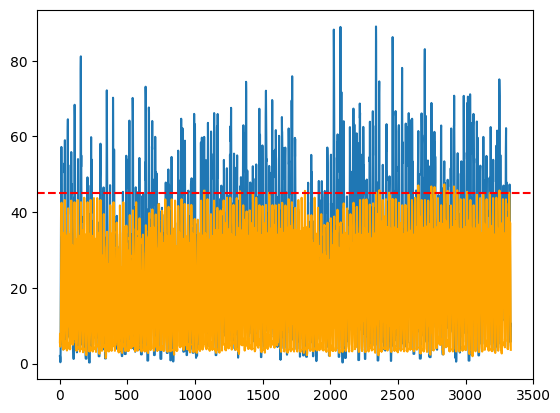

In [66]:
plt.plot(actuals_flat, label='Actuals')
plt.plot(y_pred, label=model_name, color='orange')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')

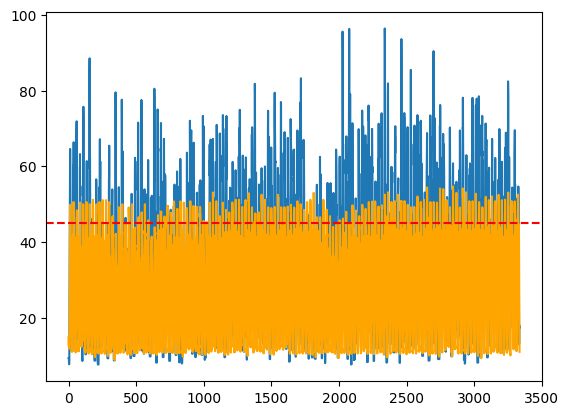

In [67]:
plt.plot(np.array(actuals_flat) + baseload, label='Actuals')
plt.plot(np.array(y_pred) + baseload, label=model_name, color='orange')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')

In [61]:
#TP: when pred is 1 and actual is 1
TP = np.sum((pred_class == 1) & (actual_class == 1))

#TN: when pred is 0 and actual is 0
TN = np.sum((pred_class == 0) & (actual_class == 0))

#FP: when pred is 1 and actual is 0
FP = np.sum((pred_class == 1) & (actual_class == 0))

#FN: when pred is 0 and actual is 1
FN = np.sum((pred_class == 0) & (actual_class == 1))

print(TP, TN)
print(FP, FN)

metrics = []

metrics.append({
  'model': model_name,
  'mae': mean_absolute_error(y_pred, actuals_flat),
  'mse': mean_squared_error(y_pred, actuals_flat),
  'acc': accuracy_score(TP, TN, FP, FN),
  'pre': precision_score(TP, FP),
  'rec': recall_score(TP, FN),
})
print(metrics)

804 1948
257 327
[{'model': 'AdaBoostRegressor', 'mae': 8.048469640389891, 'mse': 127.72640252625067, 'acc': 0.8249400479616307, 'pre': 0.7577756833176249, 'rec': 0.7108753315649867}]
